### Make plotly plots for measuring features in solar wind data

In [1]:
import pickle
import os
import numpy as np
from sunpy.time import parse_time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from heliocats import data as hd
import copy

data_path='/Users/chris/python/data/insitu_python/'

#Plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
pio.renderers.default = 'browser'

print(' ' )

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### print files in data_path

In [2]:
files = os.listdir(data_path)
files.sort()
fnames=[os.path.join(data_path, f) for f in files]
for item in files:
    print(item)

.DS_Store
ML_struct_arrays
bepi_ib_2019_now_e2k.p
bepi_ib_2019_now_rtn.p
bepi_ib_e2k_test.p
bepi_ib_rtn_test.p
bepi_ob_2019_now_e2k.p
bepi_ob_2019_now_rtn.p
bepi_ob_e2k_test.p
juno_2011_2016_rtn.p
juno_2011_2016_rtn_old.p
maven_2014_2018_removed.p
maven_2014_2018_removed_smoothed.p
maven_2014_2021_removed_no_plasma.p
maven_2014_2021_removed_smoothed_no_plasma.p
messenger_2007_2015_sceq_removed.p
msl_2012_2019_rad.p
new_data_headers.txt
noaa_dst_last_2500_now.p
noaa_dst_last_300files_now.p
noaa_dst_last_35files_now.p
noaa_rtsw
noaa_rtsw_last_2500files_now.p
noaa_rtsw_last_300files_now.p
noaa_rtsw_last_35files_now.p
noaa_rtsw_march_2023.p
noaa_xray2_last_7days_now.p
noaa_xray_last_7days_now.p
omni_1963_now.p
plots
plots_positions
plots_sun
positions_psp_solo_sta_bepi_wind_juno_juice_ulysses_planets_HEEQ_10min_degrees.p
positions_psp_solo_sta_bepi_wind_juno_juice_ulysses_planets_HEEQ_10min_rad.p
positions_psp_solo_sta_bepi_wind_juno_juice_ulysses_planets_HEEQ_1hour_degrees.p
positions_psp

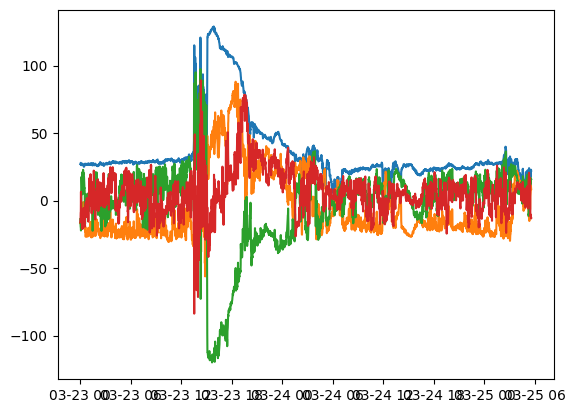

In [13]:
#file='solo_2020_now_rtn.p'

#file='psp_2018_now_rtn.p'
#file='psp_rtn_test.p'

#file='solo_rtn_2024-03-23.p'

file='solo_rtn_2024-03-25.p'

#file='bepi_ib_2019_now_rtn.p'  #preferred ib over ob
#file='bepi_ob_2019_now_rtn.p'

#file='stereoa_2007_now_rtn.p'
#file='stereoa_beacon_rtn_last_300days_now.p'
#file='stereoa_beacon_rtn_last_35days_now.p'

#file='wind_1995_now_rtn.p'


#file='noaa_rtsw_last_35files_now.p'

#file='solo_rtn_test.p'
#file='psp_rtn_test.p'

#file='ulysses_1990_2009_rtn.p'

#file='juno_2011_2016_rtn.p'
#file='juno_2011_2016_rtn_old.p'


#file='omni_1963_now.p'

[sc,header]=pickle.load(open(data_path+file, "rb" ) ) 

#start=datetime(2012,7,20)
#end=datetime(2012,7,31)

#start=datetime(1963,1,1)
#end=datetime(2024,1,1)



#start=datetime(1989,1,1)
#end=datetime(2010,1,1)



#cutout array for these dates
#start=datetime(2024,3,23,6)
#end=datetime(2024,3,26)


#cutout array for these dates
start=datetime(2023,11,1)
end=datetime(2024,12,31)


#scnum=mdates.date2num(sc.time)
startind=np.argmin(abs(start-sc.time))
endind=np.argmin(abs(end-sc.time))

sc=sc[startind:endind]

######## save cutout data if needed

#pickle_file='data/bepi_cutout_2022_march_10_april_10.p'
#pickle.dump([sc, header], open(pickle_file, "wb"))
#[bepi,hbepi]=pickle.load(open(pickle_file, "rb" ) )

plt.plot(sc.time,sc.bt)
plt.plot(sc.time,sc.bx)
plt.plot(sc.time,sc.by)
plt.plot(sc.time,sc.bz)



#header


### Use plotly for measuring times

#### with plasma data


In [14]:
nrows=5
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.3,0.2, 0.2, 0.2, 0.1])


#for column, color in zip(['b_x', 'b_y', 'b_z', 'b_tot'], ['red', 'green', 'blue', 'black']):
fig.add_trace(go.Scatter(x=sc.time, y=sc.bx, name='Bx',line_color='red'), row=1, col=1)
fig.update_yaxes(title_text="B [nT] RTN", row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.by, name='By',line_color='green'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bz, name='Bz',line_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bt, name='Bt',line_color='black'), row=1, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.vt, name='Vt',line_color='black'), row=2, col=1)
fig.update_yaxes(title_text="V [km/s]", row=2, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.np, name='Np',line_color='black'), row=3, col=1)
fig.update_yaxes(title_text="Np [ccm-3]", row=3, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.tp, name='Tp',line_color='black'), row=4, col=1)
fig.update_yaxes(title_text="Tp [K]", row=4, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.r, name='R',line_color='black'), row=5, col=1)
fig.update_yaxes(title_text="R [AU]", row=5, col=1)


#fig.update_layout(title='sc data')

#### save as vector graphics
fig.show(config = {
  'toImageButtonOptions': {
    'format': 'svg', 
    'filename': 'custom_image',
    'height': 800,
    'width': 1000,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
})

fig.write_html(f'measure.html')






### no plasma data

In [4]:
#def on_plot_click(trace, points, state):
#    if points.point_inds:
#        clicked_index = points.point_inds[0]
#        clicked_x = df['x_values'][clicked_index]
#        clicked_y = df['y_values'][clicked_index]
#        print(f"Clicked on point ({clicked_x}, {clicked_y})")


nrows=3
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.6, 0.2,0.2])

#for column, color in zip(['b_x', 'b_y', 'b_z', 'b_tot'], ['red', 'green', 'blue', 'black']):
fig.add_trace(go.Scatter(x=sc.time, y=sc.bx, name='Bx',line_color='red'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.by, name='By',line_color='green'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bz, name='Bz',line_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bt, name='Bt',line_color='black'), row=1, col=1)
fig.update_yaxes(title_text="B [nT] RTN", row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.r, name='R',line_color='black'), row=2, col=1)
fig.update_yaxes(title_text="R [AU]", row=2, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.lon, name='Longitude',line_color='black'), row=3, col=1)
fig.update_yaxes(title_text="longitude [deg] HEEQ", row=3, col=1)

# Attach the custom click event callback
#fig.data[0].on_click(on_plot_click)

fig.show()
#fig.update_layout(title='Wind')

#fig.write_html(f'measure_mag.html')


In [ ]:
[psp, solo, sta, stb, bepi, l1, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune]=pickle.load( open( 'results/positions/positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_degrees.p', "rb" ) )

In [ ]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=psp.time, y=psp.r, name='R',line_color='green'), row=1, col=1)

### for OMNI solar wind, Dst, and SSN in 2 plots

In [ ]:
file='omni_1963_now.p'

[sc,header]=pickle.load(open(data_path+file, "rb" ) ) 

#start=datetime(2012,7,20)
#end=datetime(2012,7,31)

start=datetime(1963,1,1)
end=datetime(2024,1,1)

In [ ]:
nrows=5
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.3,0.2, 0.2, 0.2, 0.1])


#for column, color in zip(['b_x', 'b_y', 'b_z', 'b_tot'], ['red', 'green', 'blue', 'black']):
fig.add_trace(go.Scatter(x=sc.time, y=sc.bx, name='Bx',line_color='red'), row=1, col=1)
fig.update_yaxes(title_text="B [nT] RTN", row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.by, name='By',line_color='green'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bz, name='Bz',line_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=sc.time, y=sc.bt, name='Bt',line_color='black'), row=1, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.vt, name='Vt',line_color='black'), row=2, col=1)
fig.update_yaxes(title_text="V [km/s]", row=2, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.np, name='Np',line_color='black'), row=3, col=1)
fig.update_yaxes(title_text="Np [ccm-3]", row=3, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.dst, name='Dst',line_color='black'), row=4, col=1)
fig.update_yaxes(title_text="Dst [nT]", row=4, col=1)


#fig.update_layout(title='sc data')

fig.write_html(f'omni.html')
fig.show()

In [ ]:
### Dst and Sunspot number

nrows=2
#init_notebook_mode(connected = True)
#init_notebook_mode(connected = False)

#fig=plt.figure(figsize=(10,6), dpi=150)

fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True,row_heights=[0.5,0.5])

fig.add_trace(go.Scatter(x=sc.time, y=sc.spot, name='SSN',line_color='red'), row=1, col=1)
fig.update_yaxes(title_text="SSN", row=1, col=1)

fig.add_trace(go.Scatter(x=sc.time, y=sc.dst, name='Dst',line_color='black'), row=2, col=1)
fig.update_yaxes(title_text="Dst [nT]", row=2, col=1)


#fig.update_layout(title='sc data')

fig.write_html(f'dst_ssn.html')
fig.show()

## scaling

In [ ]:

import seaborn as sns
sns.set_context('paper')
sns.set_style('whitegrid')

fig=plt.figure(1, figsize=(10,5), dpi=100) #full hd


scale=1/0.40**(-1.5)

scale2=1/0.40**(-2.0)
scale3=1/0.40**(-1.0)


bts=sc.bt*scale
bxs=sc.bx*scale
bys=sc.by*scale
bzs=sc.bz*scale


bzs2=sc.bz*scale2
bzs3=sc.bz*scale3



plt.plot(sc.time,bts,'-k')
#plt.plot(sc.time,bxs,'-r')
#plt.plot(sc.time,bys,'-g')
plt.plot(sc.time,bzs,'-b')

#plt.fill_between(sc.time, bzs, color='skyblue', alpha=0.3)

#plt.plot(sc.time,bzs2,'--b')
#plt.plot(sc.time,bzs3,'--b')

plt.ylabel('B [nT] RTN ') 
plt.title('SolO RTN Bn (blue) and Bt (black) scaled with exponents -1.0 to -2.0')


plt.fill_between(sc.time, bzs3, bzs2,color='lightblue', interpolate=True)




In [ ]:
def calc_coupling_newell(by, bz, v):
    #Empirical Formula for dFlux/dt - the Newell coupling
    #e.g. paragraph 25 in Newell et al. 2010 doi:10.1029/2009JA014805
    #input: needs arrays for by, bz, v    
    
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = 0.001
    tc = np.arctan2(by,bztemp)     #calculate clock angle (theta_c = t_c)
    neg_tc = bt*np.cos(tc)*bz < 0  #similar to IDL code sol_coup.pro
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    nc = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    
    return nc


def nc_weights(nc):    

    #this function is for 1 hour time resolution
    nc_weight=np.zeros(len(nc))

    prev_hour_weight = 0.65    # reduce weighting by factor with each hour back
    
    weights=np.zeros(4)

    weights[3] = 1  #the current fraction of hour is weighted as linear
    weights[2] = prev_hour_weight  
    weights[1] = prev_hour_weight**2  
    weights[0] = prev_hour_weight**3      
    
    for i in np.arange(4,len(nc)):
        #add and normalize
        nc_weight[i] = np.round(np.nansum(nc[i-3:i+1]*weights)/ np.nansum(weights),1)    
    
    return nc_weight

print(' ')
print('calculate Newell coupling without propagation first')
print(' ')
#n-> dst
#w-> solar wind



vassumed=np.zeros(np.size(bzs))+820

#minute resolution
solo_nc=calc_coupling_newell(bys,bzs,vassumed)/4421
#interpolate to 1 hour first


time_hourly=np.array([
datetime(2024, 3, 23, 12, 0),
datetime(2024, 3, 23, 13, 0),
datetime(2024, 3, 23, 14, 0),
datetime(2024, 3, 23, 15, 0),
datetime(2024, 3, 23, 16, 0),
datetime(2024, 3, 23, 17, 0),
datetime(2024, 3, 23, 18, 0),
]
)
solo_nci=np.interp(mdates.date2num(time_hourly),mdates.date2num(sc.time),solo_nc)



#then do weighting
solo_nc_fin=nc_weights(solo_nci)


plt.title('Newell coupling from Solar Orbiter data')

plt.ylabel('Nc')

plt.plot(sc.time,solo_nc,alpha=0.5)
plt.plot(time_hourly,solo_nci,'ok')
plt.plot(time_hourly,solo_nc_fin,'-r')



In [ ]:


#check positions in positions file and in data file

#plt.plot(solo.time,solo.lat,'b-')
#plt.plot(pos[1].time,np.rad2deg(pos[1].lat),'k-')   

#from plotly.subplots import make_subplots
#fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
#fig.add_trace(go.Scatter(x=solo.time, y=solo.lat, name='lat solo',line_color='red'))
#fig.add_trace(go.Scatter(x=mdates.num2date(pos[1].time), y=np.rad2deg(pos[1].lat), name='lat pos',line_color='green'))

#fig.write_html(f'measure.html')


In [ ]:
#print('load Solar Orbiter SCEQ')
#filesolo='solo_2020_april_2022_sep_mag_sceq.p'
#solo=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=solo
#sc_label='Solar Orbiter'
#start1='2022-Jan-1 00:00'
#end1='2022-Jun-30 00:00'


#print('load Solar Orbiter SCEQ')
#filesolo='solo_2020_april_2022_june_rtn.p'
#solo=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=solo
#sc_label='Solar Orbiter'
#start1='2022-Jan-1 00:00'
#end1='2022-Jun-30 00:00'

#print('PSP SCEQ')
#filepsp='psp_2022_add_mag_sceq.p'
#psp=pickle.load(open(data_path+filepsp, "rb" ) ) 
#filepsp='psp_2022_add_mag_rtn.p'
#psp=pickle.load(open(data_path+filepsp, "rb" ) ) 

#sc=psp
#sc_label='PSP'
#start1='2022-Jan-1 00:00'
#end1='2022-Mar-31 00:00'


#print('wind HEEQ')
#filesolo='wind_2018_now_heeq.p'
#[wind,windh]=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=wind
#sc_label='Wind'
#start1='2022-Sep-1 00:00'
#end1='2022-Nov-11 00:00'


#print('load bepi')
#file='bepi_2021_2022_ib_sceq.p'
#file='bepi_2021_2022_ib_sceq.p'

#bepi=pickle.load(open(data_path+file, "rb" ) ) 
#sc=bepi
#sc_label='Bepi'
#start1='2022-Apr-1 00:00'
#end1='2022-Nov-31 00:00'


#print('load sta')
#filesolo='stereoa_2020_now_sceq_beacon.p'
#[sta,stah]=pickle.load(open(data_path+filesolo, "rb" ) ) 
#sc=sta
#sc_label='STEREO-A'
#start1='2022-Feb-1 00:00'
#end1='2022-Nov-11 00:00'



####### select parts for plotting
sc=sc[-100000:-1]

#sc[0:1]

